In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
import itertools   
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import sklearn


In [3]:
from google.colab import drive
drive.mount("./gdrive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
!unzip "./gdrive/My Drive/A_02_5_data.zip" 



In [0]:
data_dir='/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset'

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(350),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


val_transforms = transforms.Compose([transforms.Resize(350),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])



In [0]:
test_transforms = transforms.Compose([transforms.Resize(350),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [8]:
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=val_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


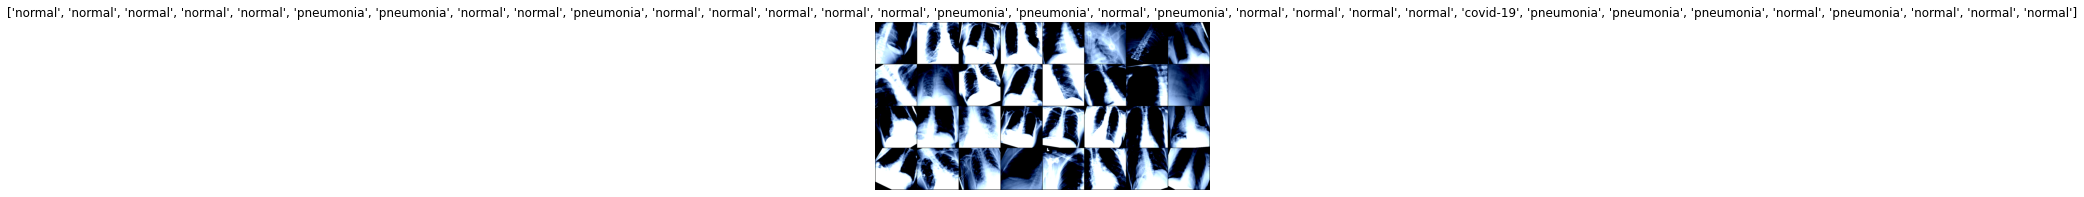

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def getResnet(withSigmoid):
  resnet=models.resnet34(pretrained=True)
  num_features=resnet.fc.in_features
  features = list(resnet.fc.children())[:-1] # Remove last layer
  features.extend([nn.Linear(num_features, 360)])
  features.extend([nn.ReLU(inplace=True)])
  features.extend([nn.Linear(360, len(class_names))])
  if(withSigmoid):
    features.extend([nn.Sigmoid()])
  # features.extend([nn.Softmax()])
  resnet.fc=nn.Sequential(*features)
  return resnet


In [0]:
def getResnet1FC():
  resnet=models.resnet34(pretrained=True)
  num_features=resnet.fc.in_features
  features = list(resnet.fc.children())[:-1] # Remove last layer
  features.extend([nn.Linear(num_features, len(class_names))]) 
  
  resnet.fc=nn.Sequential(*features)
  return resnet

In [0]:
def getVGG():
  vgg16 = models.vgg16(pretrained=True)
  num_features = vgg16.classifier[6].in_features
  features = list(vgg16.classifier.children())[:-1]
  features.extend([nn.Linear(num_features, 360)])
  features.extend([nn.ReLU(inplace=True)])
  features.extend([nn.Linear(360, len(class_names))])
  vgg16.classifier = nn.Sequential(*features)
  return vgg16




In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma        
        

    def forward(self, inputs, targets):
        inputsStable=nn.functional.softmax(inputs,dim=-1)
        # inputsStable=nn.functional.sigmoid(inputs)
        eps=1e-7
        inputsStable = inputsStable.clamp(eps, 1. - eps)        
        loss = -1 * targets * torch.log(inputsStable) # cross entropy        
        loss = loss * (1 - inputsStable) ** self.gamma # focal loss        
        loss=loss*self.alpha        
        return loss.sum()


In [0]:

def train(model,Epochs,Optimizer,Criterion,modelName):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  model.train()
  k=0

  EpochlosslistTrain=[]
  EpochlosslistVal=[]

  EpochAccListTrain=[]
  EpochAccListVal=[]
      
  for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      pbar = tqdm(enumerate(trainloader))
      i=0
      
      losslistTrain=[]
      losslistVal=[]

      AccListTrain=[]
      AccListVal=[]


      
      
      nb_digits = 3 
      

      for data,valData in itertools.zip_longest(trainloader,valloader):
          
          correct = 0
          total = 0
          # get the inputs
          inputs, labels = data

          label_onehot = torch.FloatTensor(len(labels), nb_digits)    

          label_onehot.zero_()
          label_onehot.scatter_(1, labels.data.unsqueeze(dim=1), 1)
          label_onehot=label_onehot.to(device)

          inputs, labels = inputs.to(device), labels.to(device)

          if(valData is not None):
            val_input,val_labels=valData

            val_label_onehot=torch.FloatTensor(len(val_labels), nb_digits)
            val_label_onehot.zero_()
            val_label_onehot.scatter_(1,val_labels.data.unsqueeze(dim=1),1.0)
            val_label_onehot=val_label_onehot.to(device)


            val_input,val_labels = val_input.to(device), val_labels.to(device)
            
            val_output=model(val_input)
            
            val_loss = Criterion(val_output, val_label_onehot)          


            # _, val_predicted = torch.max(val_output.data, 1)
            # val_total = val_labels.size(0)
            # val_correct = (val_predicted == val_labels).sum().item()
            # val_acc=100*val_correct/val_total        
            # AccListVal.append(val_acc)


            losslistVal.append(val_loss.data.item())  

          Optimizer.zero_grad()
          outputs = model(inputs)               #----> forward pass
          # print(outputs)
          # print(label_onehot)

          loss = Criterion(outputs, label_onehot)   #----> compute loss
          loss.backward()                     #----> backward pass
          Optimizer.step()                    #----> weights update

          

          # _, predicted = torch.max(outputs.data, 1)
          # total += labels.size(0)
          # correct += (predicted == labels).sum().item()
          # acc=100 * correct / total
          # AccListTrain.append(acc)



          losslistTrain.append(loss.data.item())






          # print statistics
          running_loss += loss.item()
          
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))
          i+=1
      # break
      lossVal=sum(losslistVal)/len(losslistVal)
      # accVal=sum(AccListVal)/len(AccListVal)

      losstrain=sum(losslistTrain)/len(losslistTrain)
      # acctrain=sum(AccListTrain)/len(AccListTrain)

      
      EpochlosslistTrain.append(losstrain)
      EpochlosslistVal.append(lossVal)

      # EpochAccListTrain.append(acctrain)
      # EpochAccListVal.append(accVal)
        

      fileName="/content/gdrive/My Drive/Models/"+modelName
      torch.save(model.state_dict(), fileName)
  return EpochlosslistTrain,EpochlosslistVal


  print('Finished Training')       


In [0]:
def DrawCurves(countList,EpochList,y_AxisLabel,title):
  plt.plot(countList, EpochList)
  # Label the axes
  plt.xlabel('epoch')
  plt.ylabel(y_AxisLabel)
  #label the figure
  plt.title(title)
  plt.show()

In [0]:
def GetConfMatrix(model):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  correct = 0
  total = 0
  trainPred=[]
  trainLabel=[]
  validPred=[]
  validLabel=[]
  
  with torch.no_grad():
      for traindata,valdata in itertools.zip_longest(trainloader,valloader):
          

          #train Part
          imagesTrain, labelsTrain = traindata
          imagesTrain, labelsTrain = imagesTrain.to(device), labelsTrain.to(device)
          outputsTrain = model(imagesTrain)
          # print(outputsTrain)
          _, predictedTrain = torch.max(outputsTrain.data, 1)
          # print("------")
          # print(predictedTrain)
          for t, p in zip(labelsTrain.view(-1), predictedTrain.view(-1)):
            trainLabel.append(t.data.item())
            trainPred.append(p.data.item())
            
          
            #valid Part
          if(valdata is not None):
            imagesval, labelsval = valdata
            imagesval, labelsval = imagesval.to(device), labelsval.to(device)
            outputsval = model(imagesval)
            _, predictedval = torch.max(outputsval.data, 1)
            total += labelsval.size(0)
            correct += (predictedval == labelsval).sum().item()
            for t, p in zip(labelsval.view(-1), predictedval.view(-1)):
              validPred.append(p.data.item())
              validLabel.append(t.data.item())           
            

  print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
  train_conf=confusion_matrix(trainLabel,trainPred)
  valid_conf=confusion_matrix(validLabel,validPred)
  f1ScoreValid=sklearn.metrics.f1_score(validLabel,validPred,average=None)
  f1ScoreTrain=sklearn.metrics.f1_score(trainLabel,trainPred,average=None)
  return train_conf,valid_conf,f1ScoreValid,f1ScoreTrain

  

## Resnet with 2 fc Layer

In [0]:
# criter = nn.BCEWithLogitsLoss()
res=getResnet(False)
criter =FocalLoss()

optimis = optim.SGD(res.parameters(), lr=0.001, momentum=0.9)

Epochs=5
modName="Resnet_2_Focal.pth"

EpochlosslistTrain,EpochlosslistVal=train(res,Epochs,optimis,criter,modName)


In [62]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(res)

Accuracy of the network on the 10000 test images: 91 %


In [63]:
print(train_conf)
print(valid_conf)
print(f1ScoreValid)
print(f1ScoreTrain)


[[ 132   38   30]
 [   8 3856  136]
 [  44  379 1577]]
[[ 22   5   1]
 [  2 390   8]
 [ 13  23 164]]
[0.67692308 0.95354523 0.87935657]
[0.6875     0.93218905 0.84263959]


In [0]:
countList=[]
for x in range(Epochs):
  countList.append(x)

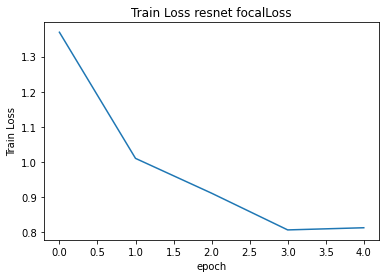

In [68]:
DrawCurves(countList,EpochlosslistTrain,"Train Loss","Train Loss resnet focalLoss")

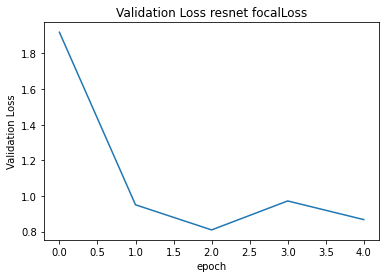

In [69]:
DrawCurves(countList,EpochlosslistVal,"Validation Loss","Validation Loss resnet focalLoss")

## ResNet with BCE loss

In [0]:
criter = nn.BCEWithLogitsLoss()
res=getResnet(False)

optimis = optim.SGD(res.parameters(), lr=0.001, momentum=0.9)

Epochs=5
modName="Resnet_2_BCE.pth"

EpochlosslistTrain,EpochlosslistVal=train(res,Epochs,optimis,criter,modName)

In [0]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(res)

In [72]:
print(train_conf)
print(valid_conf)
print(f1ScoreValid)
print(f1ScoreTrain)


[[   0   61  139]
 [   0 3834  166]
 [   0  395 1605]]
[[  0  18  10]
 [  0 380  20]
 [  0  24 176]]
[0.         0.92457421 0.86699507]
[0.         0.92496984 0.82097187]


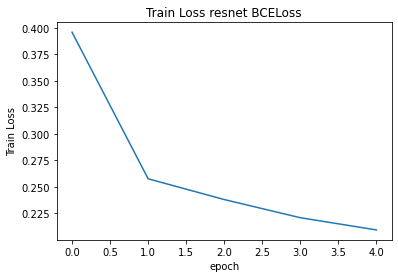

In [75]:
DrawCurves(countList,EpochlosslistTrain,"Train Loss","Train Loss resnet BCELoss")

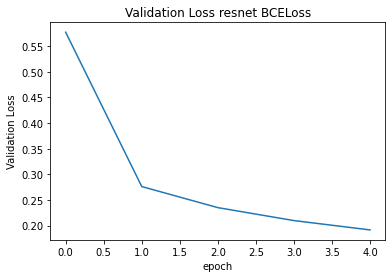

In [78]:
DrawCurves(countList,EpochlosslistVal,"Validation Loss","Validation Loss resnet BCELoss")

## VGG16 with focal loss

In [0]:
vgg16=getVGG()
criter =FocalLoss()
optimis = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Epochs=5
modName="Vgg_2_focal.pth"

EpochlosslistTrain,EpochlosslistVal=train(vgg16,Epochs,optimis,criter,modName)

In [83]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(vgg16)

Accuracy of the network on the 10000 test images: 89 %


In [84]:
print(train_conf)
print()
print(valid_conf)
print()
print(f1ScoreValid)
print()
print(f1ScoreTrain)

[[  44   85   71]
 [   0 3962   38]
 [   5  690 1305]]

[[ 14  10   4]
 [  1 396   3]
 [  3  45 152]]

[0.60869565 0.9306698  0.84679666]

[0.35341365 0.90694746 0.76449912]


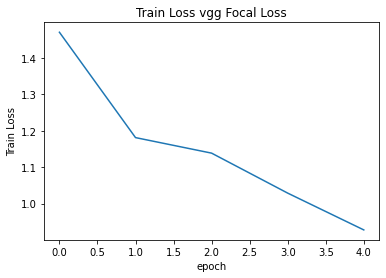

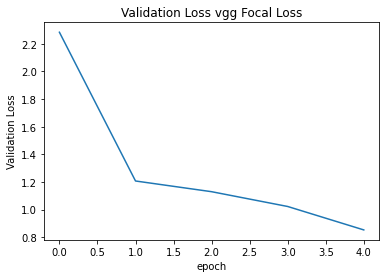

In [86]:
DrawCurves(countList,EpochlosslistTrain,"Train Loss","Train Loss vgg Focal Loss")
DrawCurves(countList,EpochlosslistVal,"Validation Loss","Validation Loss vgg Focal Loss")

## vgg16 with BCE loss

In [0]:
vgg16=getVGG()
criter =nn.BCEWithLogitsLoss()
optimis = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

Epochs=5
modName="Vgg_2_BCE.pth"

EpochlosslistTrain,EpochlosslistVal=train(vgg16,Epochs,optimis,criter,modName)

In [88]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(vgg16)

Accuracy of the network on the 10000 test images: 89 %


In [89]:
print(train_conf)
print()
print(valid_conf)
print()
print(f1ScoreValid)
print()
print(f1ScoreTrain)

[[  63   60   77]
 [   1 3900   99]
 [  14  395 1591]]

[[  9  16   3]
 [  6 390   4]
 [ 15  23 162]]

[0.31034483 0.94089264 0.87804878]

[0.45323741 0.93357271 0.84470401]


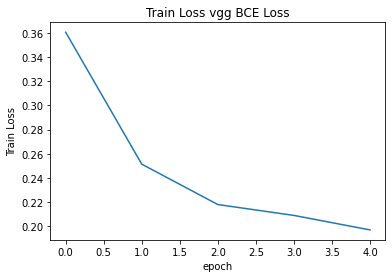

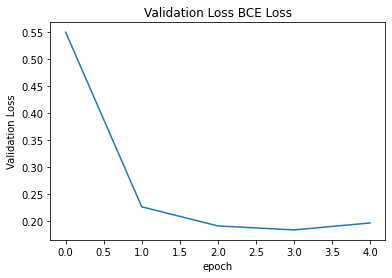

In [90]:
DrawCurves(countList,EpochlosslistTrain,"Train Loss","Train Loss vgg BCE Loss")
DrawCurves(countList,EpochlosslistVal,"Validation Loss","Validation Loss BCE Loss")

## Resnet with 1FC layer

In [0]:

res=getResnet1FC()
criter =FocalLoss()

optimis = optim.SGD(res.parameters(), lr=0.001, momentum=0.9)

Epochs=5
modName="Resnet_2_1FC_Focal.pth"

EpochlosslistTrain,EpochlosslistVal=train(res,Epochs,optimis,criter,modName)


In [19]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(res)

Accuracy of the network on the 10000 test images: 83 %


In [19]:
print(train_conf)
print()
print(valid_conf)
print()
print(f1ScoreValid)
print()
print(f1ScoreTrain)

[[ 114   37   49]
 [   8 3839  153]
 [  25  385 1590]]

[[ 16   8   4]
 [  3 391   6]
 [  5  29 166]]

[0.61538462 0.94444444 0.88297872]

[0.65706052 0.92942743 0.83860759]


## resnet with 2 fc layer and changed lr

In [0]:
res=getResnet(False)
criter =FocalLoss()

optimis = optim.SGD(res.parameters(), lr=0.01, momentum=0.9)

Epochs=5
modName="Resnet_2_Focal.pth"

EpochlosslistTrain,EpochlosslistVal=train(res,Epochs,optimis,criter,modName)


In [65]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(res)

Accuracy of the network on the 10000 test images: 87 %


In [67]:
print(train_conf)
print()
print(valid_conf)
print()
print(f1ScoreValid)
print()
print(f1ScoreTrain)

[[   0   64  136]
 [   0 3673  327]
 [   0  423 1577]]

[[  0   9  19]
 [  0 379  21]
 [  0  28 172]]

[0.         0.92892157 0.83495146]

[0.         0.9002451  0.78069307]


In [0]:
criter = FocalLoss()
res=getResnet(False)

optimis = optim.SGD(res.parameters(), lr=0.001, momentum=0.9)

Epochs=5
modName="Resnet_2_Focal.pth"

EpochlosslistTrain,EpochlosslistVal=train(res,Epochs,optimis,criter,modName)

In [69]:
train_conf,valid_conf,f1ScoreValid,f1ScoreTrain=GetConfMatrix(res)

Accuracy of the network on the 10000 test images: 92 %


In [70]:
print(train_conf)
print()
print(valid_conf)
print()
print(f1ScoreValid)
print()
print(f1ScoreTrain)

[[ 110   35   55]
 [   8 3845  147]
 [  22  358 1620]]

[[ 17   6   5]
 [  1 385  14]
 [  3  21 176]]

[0.69387755 0.94827586 0.89113924]

[0.64705882 0.933479   0.8477237 ]


In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


data_dir2="/content/content/gdrive/My Drive/A_5_data/A_05_Part_02_Dataset/Test"
dataset = ImageFolderWithPaths(root=data_dir2, transform=test_transforms)
testLoader = torch.utils.data.DataLoader(dataset=dataset,batch_size=1, shuffle=False)



In [0]:
import ntpath
import numpy as np
def getResult(model):
  result={}
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  for  data in testLoader:
    image,label,path = data
    
    fileName=ntpath.basename(path[0])    
    
    image,label = image.to(device), label.to(device)
    output = model(image)
    print("--------")
    
    out= torch.sigmoid(output)
    out2=nn.functional.softmax(output,dim=-1)
    print(out)

    
    arr=np.zeros(3)
    temp=[]
    ind=0
    for _,value in zip(out.view(-1),out.view(-1)):
      num=value.data.item()
      if(num>0.5):
        arr[ind]=1
      ind+=1

    
    result[fileName]=arr


  return result



    
      
  
  


In [0]:
vggres=getResult(vgg16)

In [0]:
result=getResult(res)

In [0]:
final=[]
for k in vggres.keys():
  temp=[]
  print(vggres[k])
  arr=np.zeros(3)
  arr[0]=vggres[k][0]
  arr[1]=vggres[k][2]
  arr[2]=vggres[k][1]
  temp.append(k)

  temp.append(str(int(arr[0])))
  temp.append(str(int(arr[1])))
  temp.append(str(int(arr[2])))

  
  final.append(temp)
  

In [0]:
import csv


In [0]:
fileName='/content/gdrive/My Drive/final3.csv'
with open(fileName, mode='w',  newline='') as csvFile:
  FileWriter = csv.writer(csvFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for row in final:
    FileWriter.writerow(row)
